<a href="https://colab.research.google.com/github/crtwomey/DDDI2022_linreg_tutorial/blob/main/notebooks/DDDI2022_Tutorial_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear regression in a hurry

A **regression analysis** is a statistical tool for modeling the dependence of one variable on one or more other variables.

- A **variable** is something we measure that can take on some range of values, like height, weight, or eye color.

- A **model** expresses a mathematical relationship between variables.

Examples

![Regression examples](https://raw.githubusercontent.com/crtwomey/DDDI2022_linreg_tutorial/main/images/regression_examples.jpg)

- nonlinear (Gompertz growth curve for rabbit biomass)
- linear (Pearson's height heritability data)
- linear after transform (e.g. Leavitt's period-luminosity relation in astronomy)

# Review

## Mean

$n$ observations, $x_1, x_2, \ldots, x_n$.

$\mu = \frac{1}{n} \sum_{i = 1}^n x_i$

In [1]:
# example
x <- c(7, 3, 15, 15)

In [2]:
1/4 * sum(x)

[1] 10

In [3]:
mean(x)

[1] 10

## Variance

$\sigma^2 = \frac{1}{n} \sum_{i = 1}^n (x_i - \mu)^2$

In [4]:
(x - mean(x))^2

[1]  9 49 25 25

In [5]:
1/4 * sum((x - mean(x))^2)

[1] 27

In [6]:
var(x)

[1] 36

Why the discrepancy? R uses $n-1$ in the denominator instead of $n$. "Bias" refers to the fact that for small $n$, using the definition of variance given above will tend to underestimate the true population variance. This correction gives an *unbiased* estimate of the population variance. Why this works and how it's derived is outside the scope of this course.

`var(x)` $= \frac{1}{n-1}\sum_i (x_i - \mathrm{mean(x)})^2$

In [7]:
# unbiased estimate
1/(4 - 1) * sum((x - mean(x))^2)

[1] 36

## Standard deviation

$\sigma = \sqrt{\sigma^2}$

In [8]:
sqrt(var(x))

[1] 6

In [9]:
sd(x)

[1] 6

## Data: Darwin's finches

Daphne Major

![Daphne Major](https://raw.githubusercontent.com/crtwomey/DDDI2022_linreg_tutorial/main/images/daphne_major.jpg)

Variability in beak depth

![Darwin's finches](https://raw.githubusercontent.com/crtwomey/DDDI2022_linreg_tutorial/main/images/finches.jpg)

Beak depth and diet

<img src="https://raw.githubusercontent.com/crtwomey/DDDI2022_linreg_tutorial/main/images/finch_diet.jpeg" alt="Finch diet" width=400/>

In [ ]:
# load the tidyverse
options(tidyverse.quiet = TRUE)
library(tidyverse)

# set the theme for our plots and adjust the base size
theme_set(theme_minimal(base_size = 20))

# setup the size of our plot
options(repr.plot.height = 6, repr.plot.width = 10)

# location of the data csvs
account_url <- "https://raw.githubusercontent.com/crtwomey"
data_url    <- "DDDI2022_linreg_tutorial/main/data/"

# helper function for loading beak data
load_beak_data <- function(file) {
  read_csv(file.path(account_url, data_url, file),
    col_types = cols(year = col_factor()))
}

In [11]:
# load the finch beak data
finch_beaks <- load_beak_data("finch_beaks.csv")
head(finch_beaks)

year,depth_mm
<fct>,<dbl>
1976,6.1
1976,6.1
1976,6.2
1976,6.3
1976,6.2
1976,6.3


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



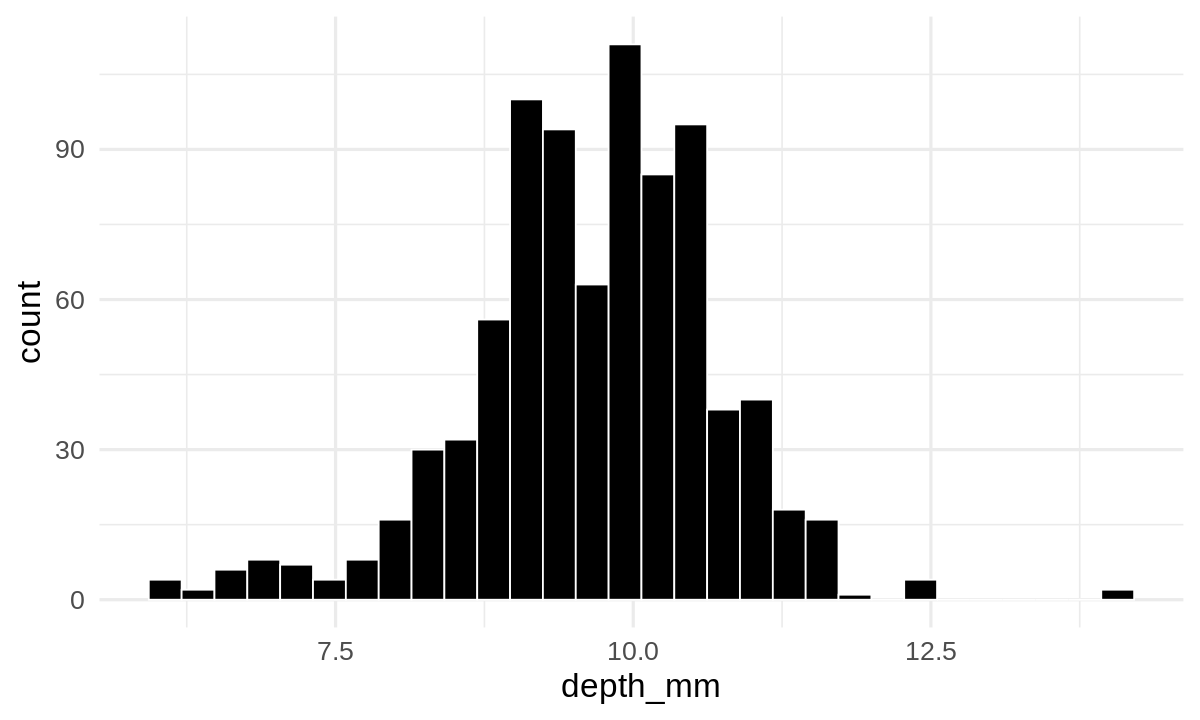

In [12]:
# histogram of finch beak depth
finch_beaks %>%
  ggplot(aes(x = depth_mm)) +
    geom_histogram(color = "white", fill = "black")

In [13]:
# mean and standard deviation of beak depth
mean(finch_beaks$depth_mm)
sd(finch_beaks$depth_mm)

[1] 9.657738

[1] 1.035456

## The normal distribution

$y \sim \mathcal{N}(\mu, \sigma^2)$

The values of $y$ are distributed according to a normal distrbution with mean $\mu$ and variance $\sigma^2$.

$p(y|\mu,\sigma^2) \propto e^{-\frac{(y - \mu)^2}{2\sigma^2}}$

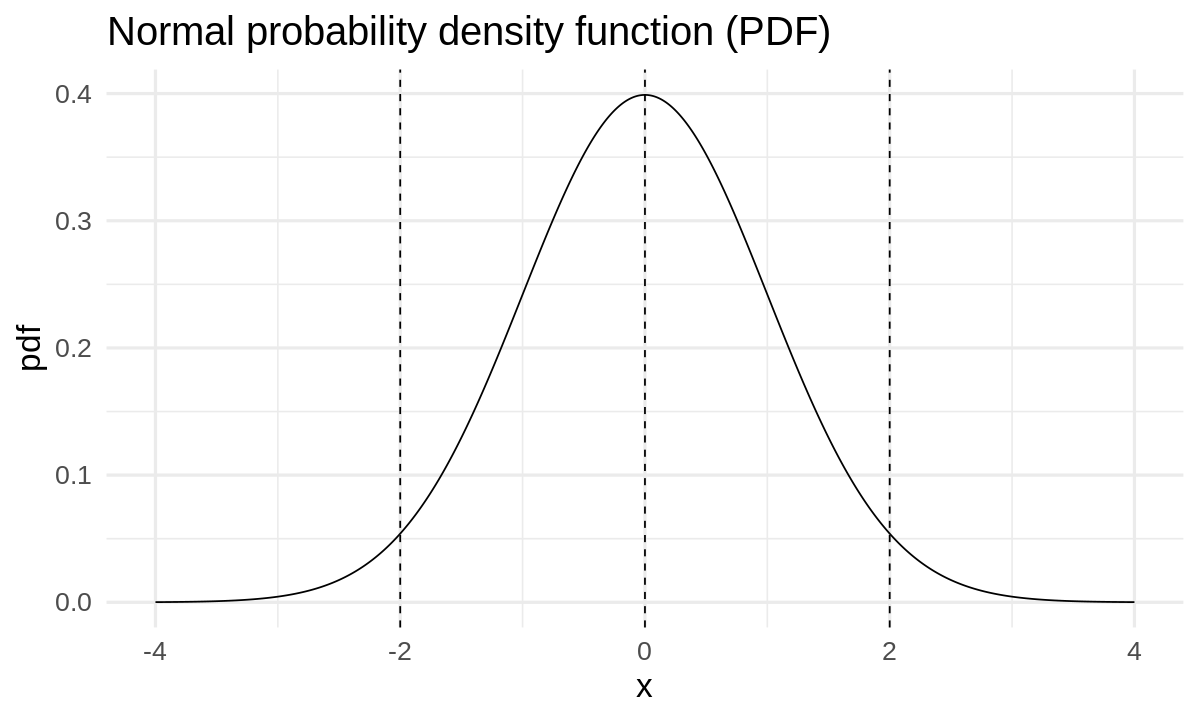

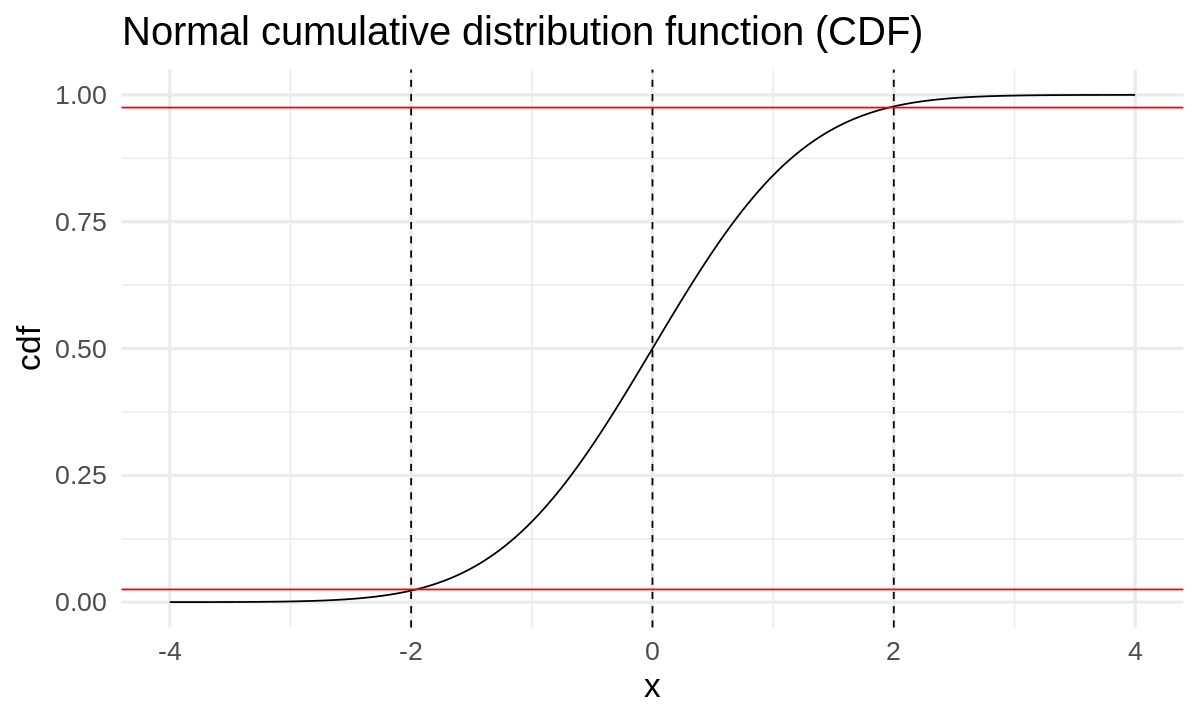

In [14]:
# let's pick a mean and variance and plot the PDF (probability density function)
# of the corresponding normal distribution
mu    <- 0
sigma <- 1

norm_example <- tibble(
  x   = seq(-4, 4, 0.01),
  pdf = dnorm(x, mean = mu, sd = sigma)
)

# PDF
norm_example %>%
  ggplot(aes(x = x, y = pdf)) +
    geom_line() +
    geom_vline(xintercept = mu, linetype = 2) +
    geom_vline(xintercept = mu + c(-2, 2) * sigma, linetype = "dashed") +
    labs(title = "Normal probability density function (PDF)")

# CDF
norm_example %>%
  mutate(cdf = pnorm(x, mean = mu, sd = sigma)) %>%
  ggplot(aes(x = x, y = cdf)) +
    geom_line() +
    geom_vline(xintercept = mu, linetype = 2) +
    geom_vline(xintercept = mu + c(-2, 2) * sigma, linetype = "dashed") +
    geom_hline(yintercept = c(0.05/2, 1 - 0.05/2), col = "red") +
    labs(title = "Normal cumulative distribution function (CDF)")

In [15]:
# quantile function for the normal distribution
qnorm(0.05/2)

[1] -1.959964

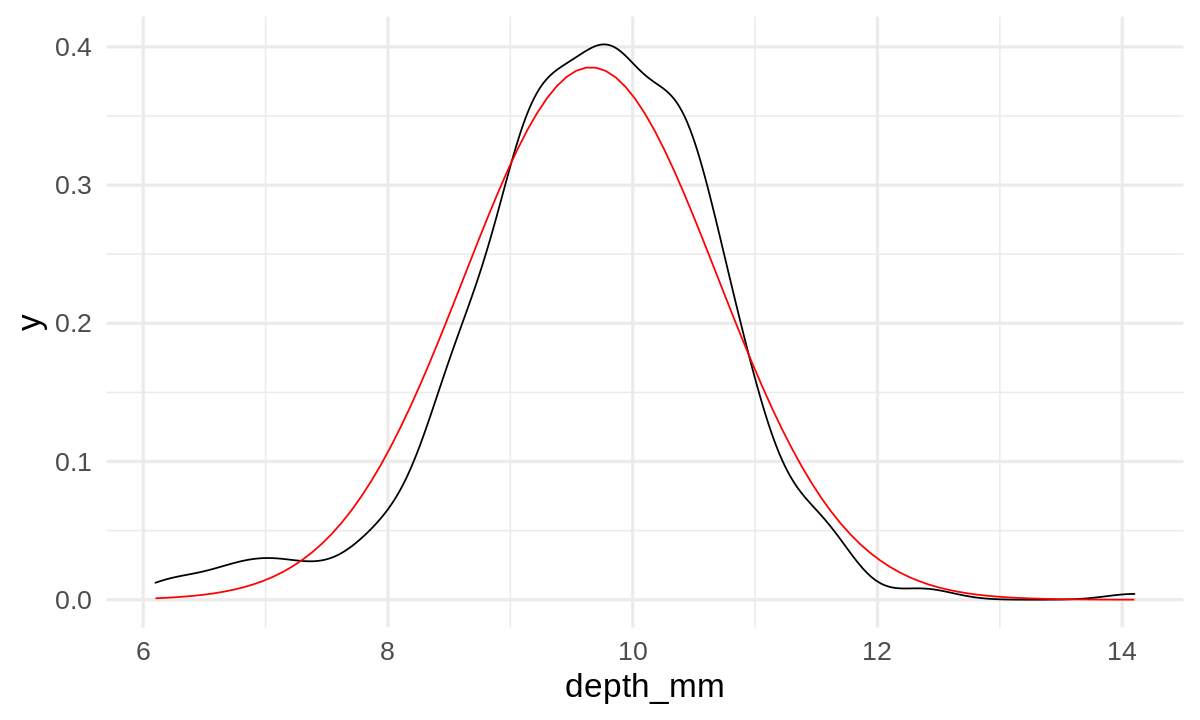

In [16]:
# compare empirical and normal distirbution
# with the same mean and variance
norm_beaks <- function(x) {
  dnorm(x,
    mean = mean(finch_beaks$depth_mm),
    sd   = sd(finch_beaks$depth_mm)
  )
}

finch_beaks %>%
  ggplot(aes(x = depth_mm)) +
    geom_density() +
    stat_function(fun = norm_beaks, color = "red")

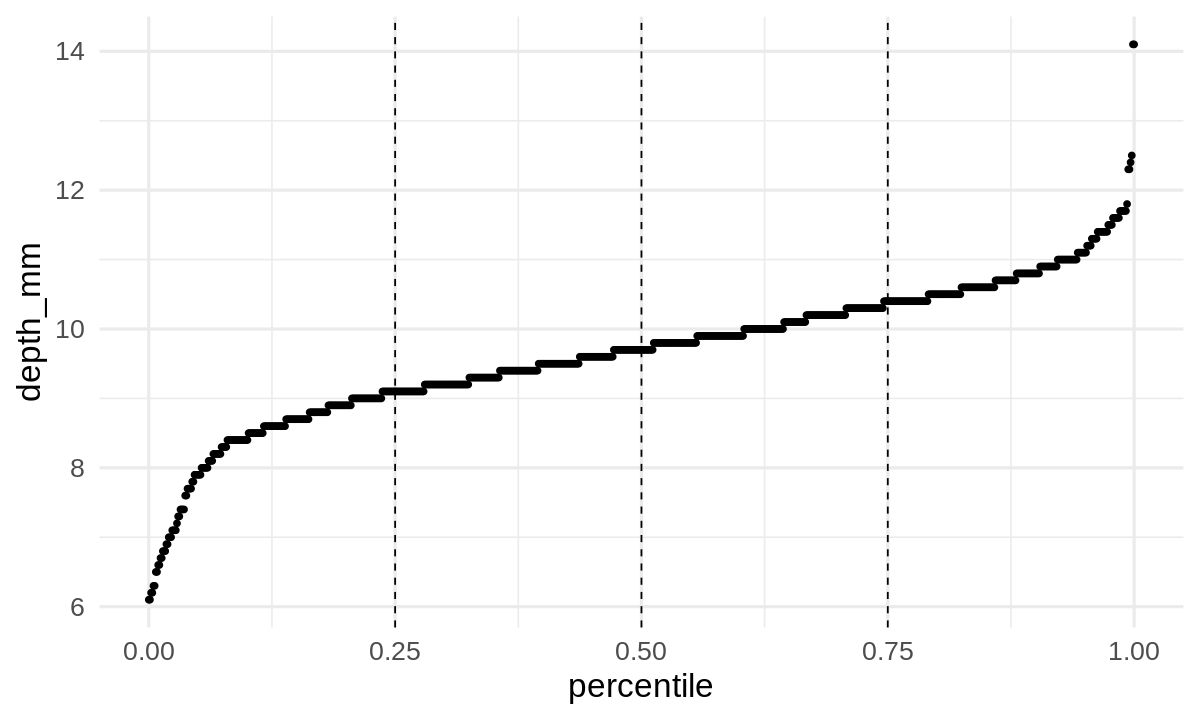

In [17]:
options(repr.plot.height = 6, repr.plot.width = 10)
finch_beaks %>%
  mutate(
    depth_mm = sort(depth_mm),
    percentile = seq(0, 1, length.out = length(depth_mm))
  ) %>%
  ggplot(aes(x = percentile, y = depth_mm)) +
    geom_point() +
    geom_vline(xintercept = c(0.25, 0.5, 0.75), linetype = "dashed")

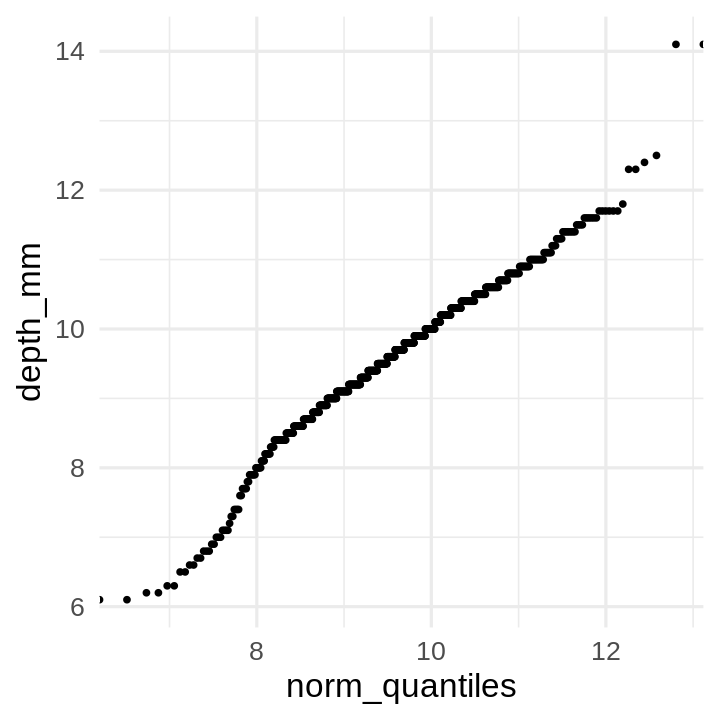

In [18]:
options(repr.plot.height = 6, repr.plot.width = 6)
finch_beaks %>%
  mutate(
    depth_mm = sort(depth_mm),
    percentile = seq(0, 1, length.out = length(depth_mm)),
    norm_quantiles = qnorm(percentile,
      mean = mean(depth_mm),
      sd = sd(depth_mm)
    )
  ) %>%
  ggplot(aes(x = norm_quantiles, y = depth_mm)) +
    geom_point() +
    geom_abline(intercept = mean(finch_beaks$depth_mm))

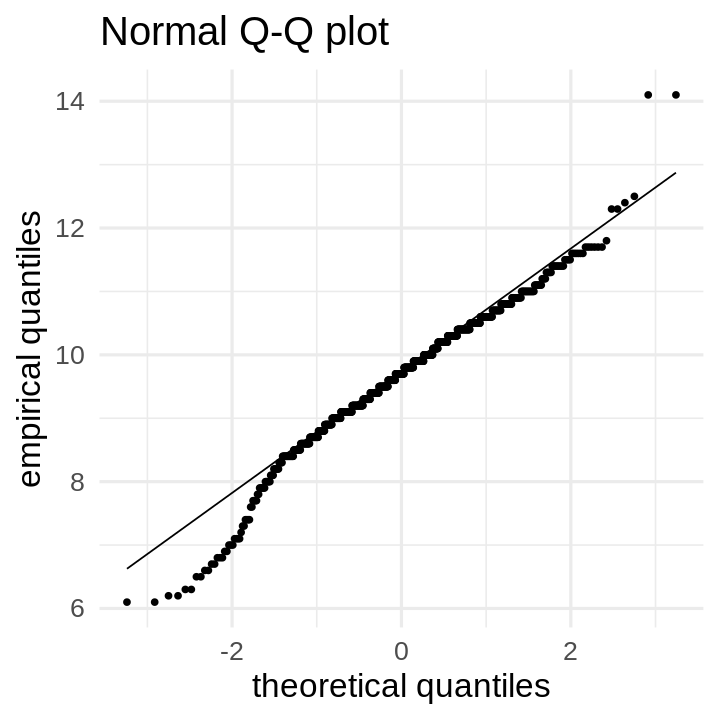

In [19]:
options(repr.plot.height = 6, repr.plot.width = 6)
finch_beaks %>%
  ggplot(aes(sample = depth_mm)) +
    stat_qq() +
    stat_qq_line() +
    labs(
      title = "Normal Q-Q plot",
      y = "empirical quantiles",
      x = "theoretical quantiles"
    )

## Quantifying uncertainty

How confident should we be in our estimate of mean beak depth? We aren't able to sample every finch on the island, and maybe our estimate would look very different with a different sample.

To answer this question, we can calculate a *confidence interval* (CI) for our estimate of mean beak depth based on our sample. The smaller the CI, the more precise our estimate.

### Bootstrap CI

Bootstrap resampling gives us a clever way to look at the precision of our estimate of the mean by using our observed sample distribution to simulate new, hypothetical sample distributions, without making strong assumptions about the sampling distribution itself.

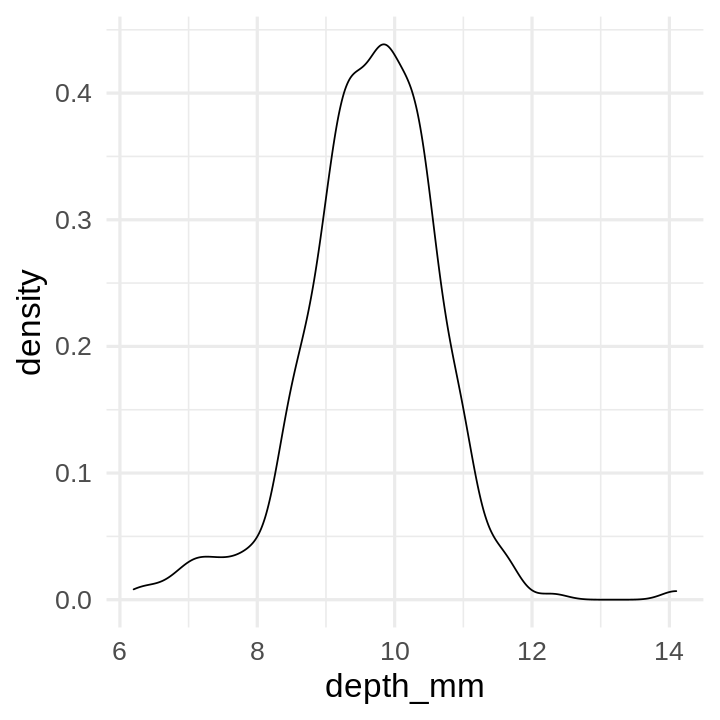

In [21]:
# example resampling the empirical distribution of beak depths
finch_beaks %>%
  mutate(depth_mm = sample(depth_mm, replace = T)) %>%
  ggplot(aes(x = depth_mm)) +
    geom_density()

In [22]:
# bootstrapping CIs by resampling with replacement
resample_mean <- function() {
  mean(sample(finch_beaks$depth_mm, replace = T))
}

In [23]:
resample_mean()

[1] 9.658929

In [24]:
resampled_means <- replicate(10000, resample_mean())

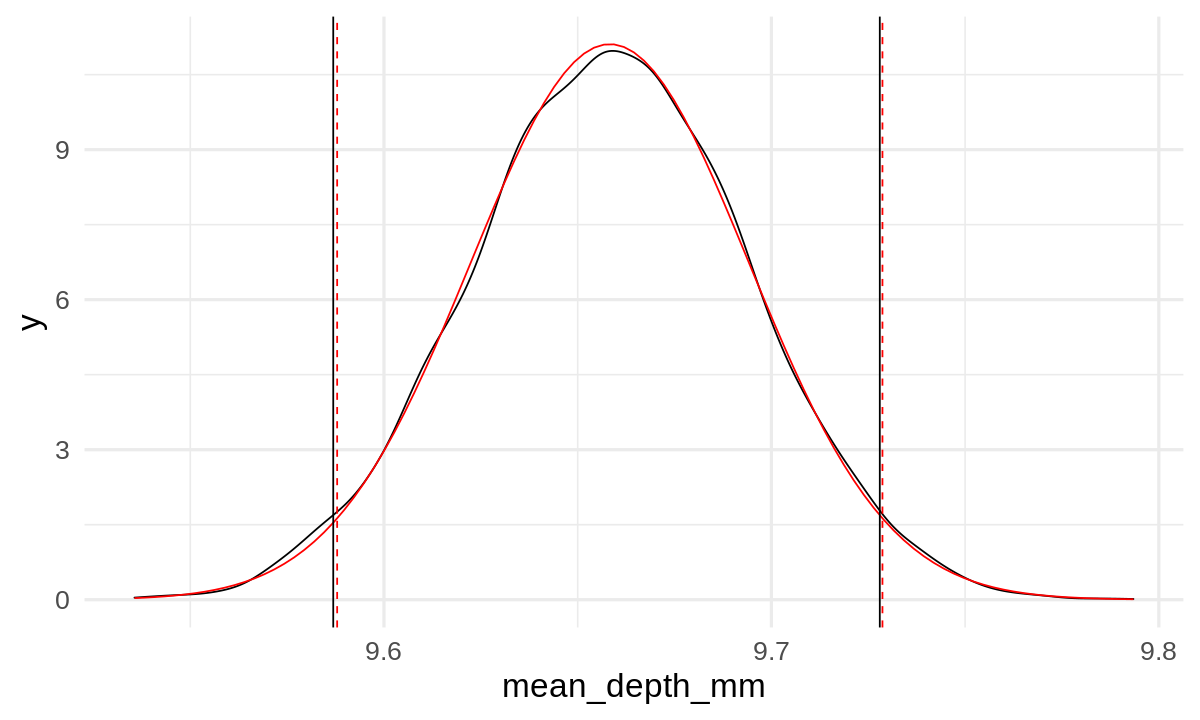

In [25]:
# bootstrap distribution
options(repr.plot.height = 6, repr.plot.width = 10)
tibble(mean_depth_mm = resampled_means) %>%
  ggplot(aes(x = mean_depth_mm)) +
    geom_density() +
    stat_function(fun = function(x) {
        dnorm(x,
          mean = mean(resampled_means),
          sd   = sd(resampled_means)
        )
      },
      color = "red"
    ) +
    geom_vline(xintercept = quantile(resampled_means, c(0.05/2, 1-0.05/2))) +
    geom_vline(xintercept = qnorm(c(0.05/2, 1-0.05/2),
        mean = mean(resampled_means),
        sd   = sd(resampled_means)
      ),
      color = "red", linetype = "dashed"
    )

In [26]:
# 95% CIs
bootstrapped_sd <- sd(resampled_means)
CI_95 <- mean(resampled_means) + c(-1.96, 1.96) * bootstrapped_sd
round(CI_95, digits=3)
round(c(-1.96, 1.96) * bootstrapped_sd, digits=3)

[1] 9.588 9.729

[1] -0.07  0.07

If we were to re-run this experiment with 100 times, 95% of the time we calculate this interval we'd expect it to contain the true population mean.

A common source of confusion: this does not imply that the true population mean has a 95% probability of falling within this CI. We won't get to this today, but to make a statement like this you would need to compute the Bayesian credible interval. This incorporates a subjective choice of a *prior* distribution on mean beak depth in order to calculate a *posterior* distribution on mean depth, given our data.

### Standard error (SE)

When the sampling distribution (in this case, the distribution of beak depths; *not* the bootstrapped distribution of mean beak depth we computed above) is approximately normally distributed, the standard error (SE), defined

$$\text{SE} = \frac{\sigma}{\sqrt{n}},$$

measures the precision of our estimate of the mean. Instead of bootstrapping, we can also compute 95% CIs in terms of this quantity.

In [27]:
# 95% CI from SE
SE <- sd(finch_beaks$depth_mm) / sqrt(length(finch_beaks$depth_mm))
CI_SE <- mean(finch_beaks$depth_mm) + c(-1.96, 1.96) * SE
round(CI_SE, digits=3)
round(c(-1.96, 1.96) * SE, digits=3)

[1] 9.588 9.728

[1] -0.07  0.07

## Drought on Daphne Major

Sometime between 1976 and 1978 there was a severe drought on Daphne Major, which affected the availability of seeds of different sizes.

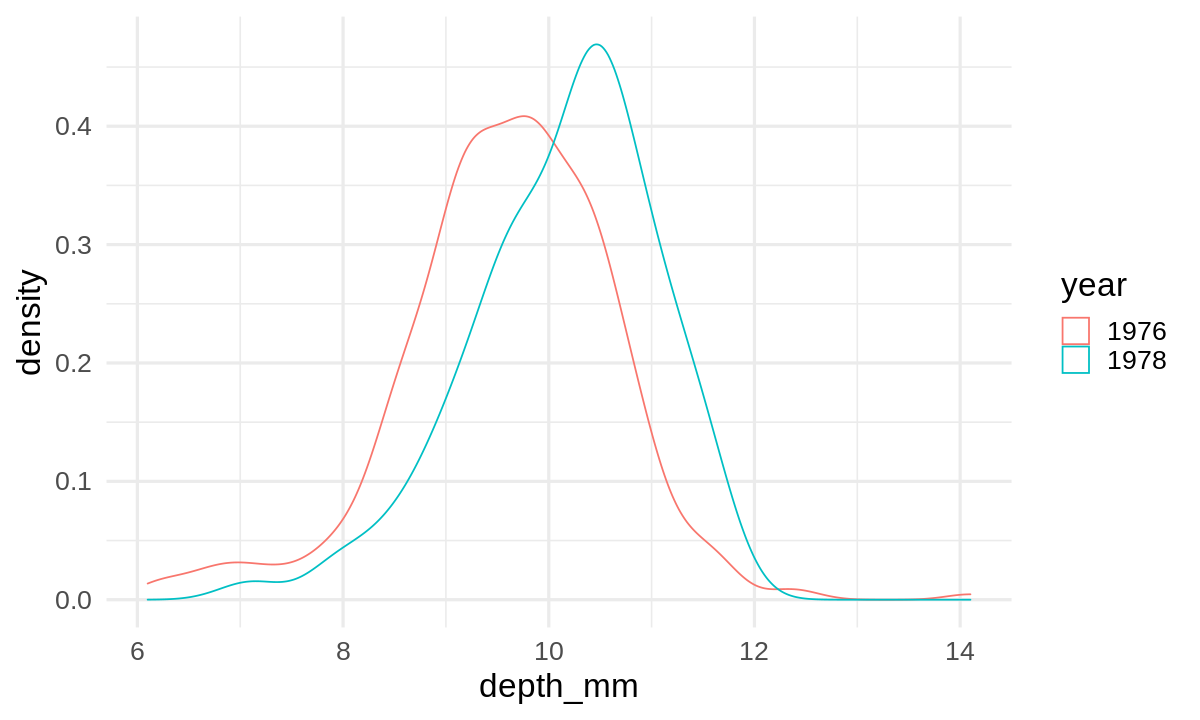

In [28]:
# distribution of beak depths pre- and post-drought
options(repr.plot.height = 6, repr.plot.width = 10)
finch_beaks %>%
  ggplot(aes(x = depth_mm, color = year)) +
    geom_density()

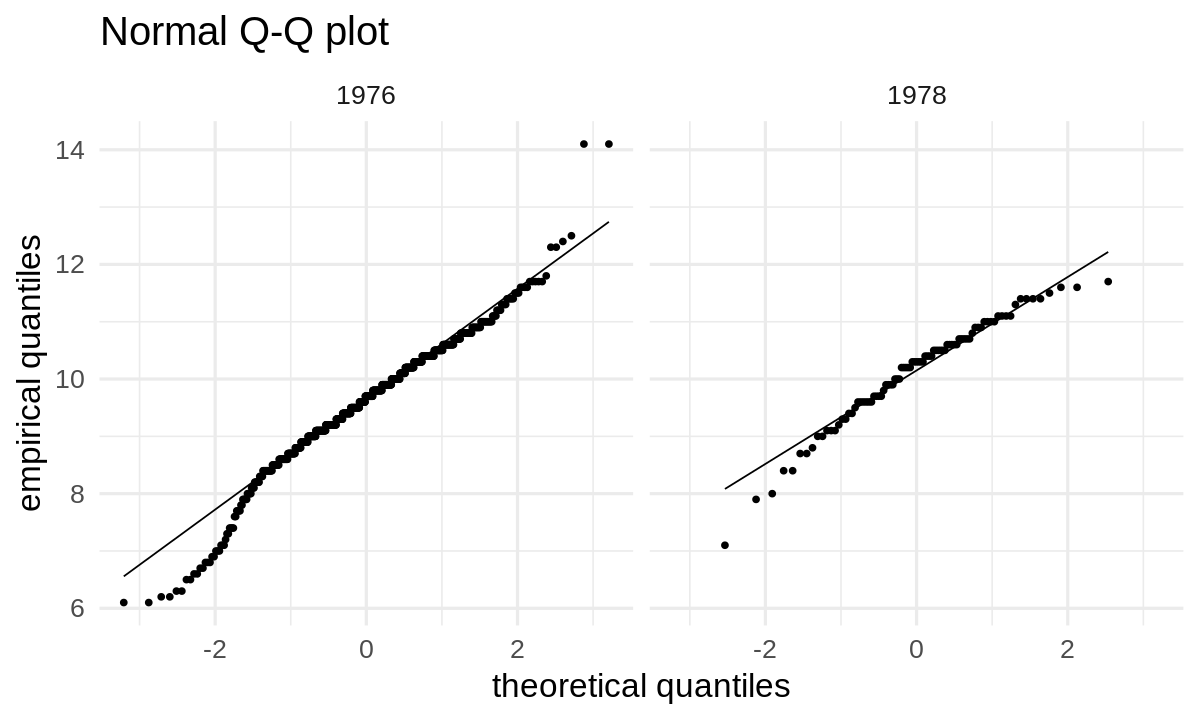

In [29]:
# QQ plots by year
options(repr.plot.height = 6, repr.plot.width = 10)
finch_beaks %>%
  ggplot(aes(sample = depth_mm)) +
    stat_qq() +
    stat_qq_line() +
    labs(
      title = "Normal Q-Q plot",
      y = "empirical quantiles",
      x = "theoretical quantiles"
    ) +
    facet_wrap(~ year)

# Regression

How does one quantity, $y$, vary as a function of one (or more) other quantities, $x$?

- $y$ is the **response** (or outcome) variable
- $x$ is the **explanatory** variable (or vector of explanatory variables)

Observations of the response variable are paired with observations of one or more explanatory variables. In the case of just one explanatory variable, this means that for each $y_i$ we also have an $x_i$.

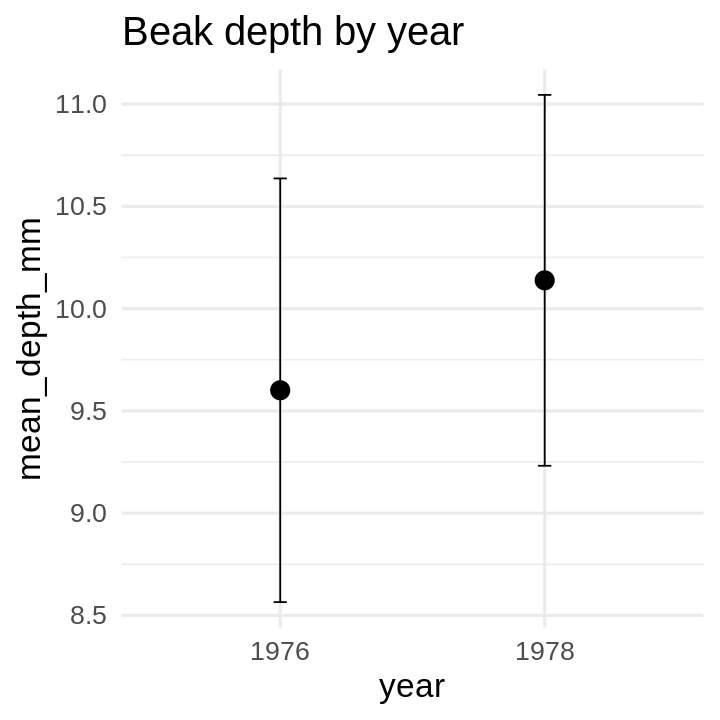

In [30]:
# How did the average beak size change after the drought?
avg_beaks <- finch_beaks %>%
  group_by(year) %>%
  summarize(
    mean_depth_mm = mean(depth_mm),
    sd_depth_mm = sd(depth_mm),
    n_samples   = n()
  )

options(repr.plot.height = 6, repr.plot.width = 6)
avg_beaks %>%
  ggplot(aes(x = year, y = mean_depth_mm)) +
    geom_point(size = 5) +
    geom_errorbar(aes(
      ymin = mean_depth_mm - sd_depth_mm,
      ymax = mean_depth_mm + sd_depth_mm,
      width = 0.05
    )) +
    labs(title = "Beak depth by year")

In [31]:
avg_beaks

year,mean_depth_mm,sd_depth_mm,n_samples
<fct>,<dbl>,<dbl>,<int>
1976,9.600799,1.0355414,751
1978,10.138202,0.9064799,89


In [32]:
diff(avg_beaks$mean_depth_mm)

[1] 0.5374033

## Linear regression

Linear regression is a regression analysis where the mean response is a linear function of the dependent variable(s). I.e., for one dependent variable,

$y_i \sim \mathcal{N}(f(x_i), \sigma^2)$

and

$\underbrace{f(x)}_{\text{expected value}} = \underbrace{\beta_0}_{\text{intercept}} + \underbrace{\beta_1}_{\text{slope}} x$

In [33]:
m <- lm(depth_mm ~ year, data = finch_beaks)

In [34]:
coef(m)

(Intercept)    year1978 
  9.6007989   0.5374033

In [35]:
summary(m)


Call:
lm(formula = depth_mm ~ year, data = finch_beaks)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.5008 -0.5382  0.0992  0.6992  4.4992 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  9.60080    0.03732 257.250  < 2e-16 ***
year1978     0.53740    0.11466   4.687 3.23e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.023 on 838 degrees of freedom
Multiple R-squared:  0.02555,	Adjusted R-squared:  0.02438 
F-statistic: 21.97 on 1 and 838 DF,  p-value: 3.233e-06


## Heritability of beak depth

So far we've seen that
- finches vary in beak depth
- beak depth is related to diet
- there's a difference in average beak depth from 1976 to 1978, likely due to a drought affecting seed availabilities

What will the beak depths of the next generation of finches on Daphne Major look like?

In [36]:
beak_heritability <- load_beak_data("beak_heritability.csv")
head(beak_heritability)

year,midparent_depth_mm,offspring_depth_mm
<fct>,<dbl>,<dbl>
1976,8.2,8.0
1976,8.4,7.8
1976,8.4,8.2
1976,9.3,7.8
1976,9.0,8.3
1976,9.0,8.5


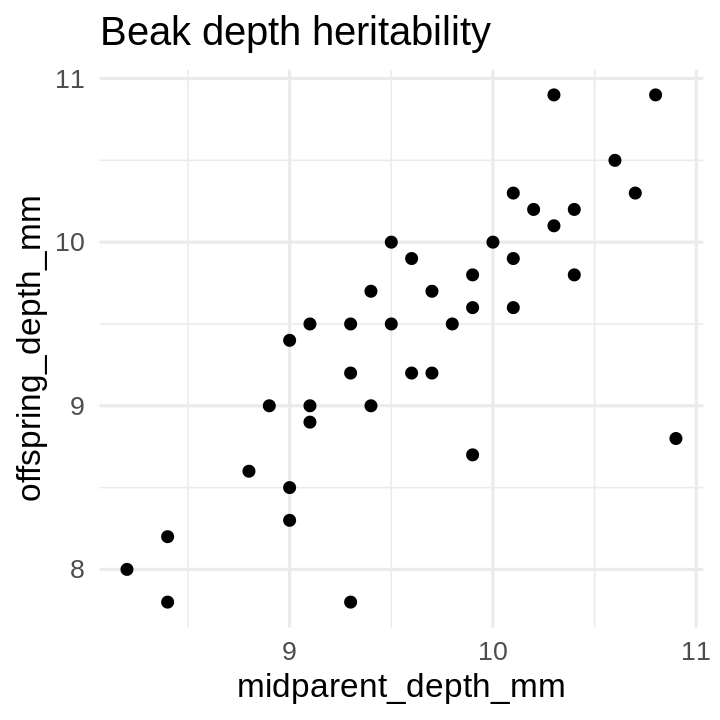

In [37]:
options(repr.plot.height = 6, repr.plot.width = 6)
beak_heritability %>%
  ggplot(aes(x = midparent_depth_mm, y = offspring_depth_mm)) +
    geom_point(size = 3) +
    labs(title = "Beak depth heritability")

## Residuals

How closely does the output of our model match a given data point?

The **residual** is the difference between what our model predicts based on a given input, $x$, and the value of the response variable, $y$, that was actually observed.

The residual of the $i$-th observation is

$$y_i - f(x_i)$$


In [38]:
# first try... let's just make a guess
f <- function(x) 0 + 1*x

guess <- beak_heritability %>%
  mutate(
    expected_offspring_depth_mm = f(midparent_depth_mm),
    residuals = offspring_depth_mm - f(midparent_depth_mm),
  )

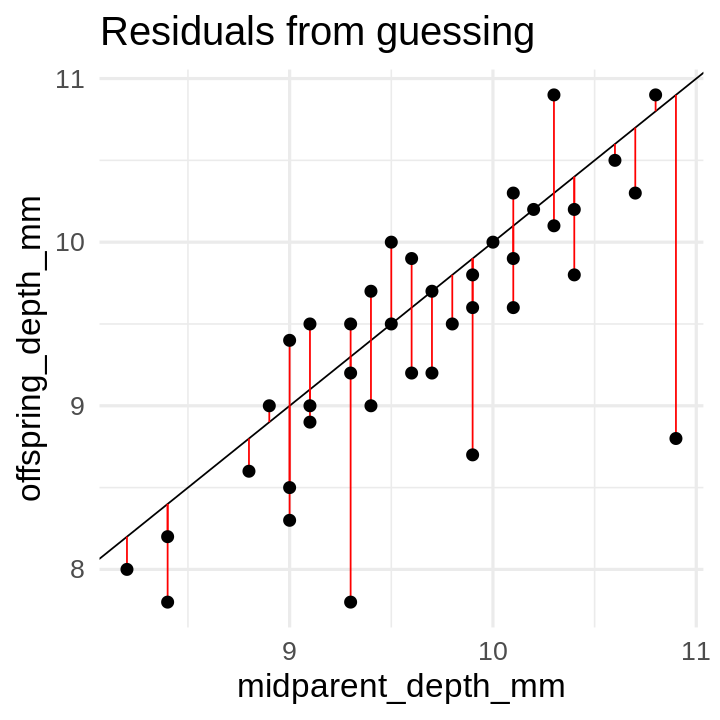

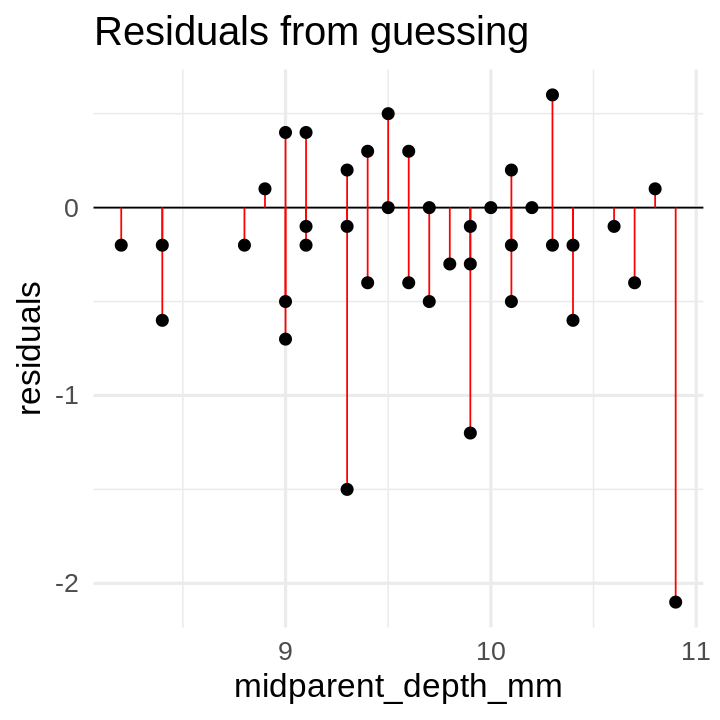

In [39]:
guess %>%
  ggplot(aes(x = midparent_depth_mm, y = offspring_depth_mm)) +
  geom_abline(
    intercept = 0,
    slope = 1
  ) +
  geom_segment(color = "red", aes(
    xend = midparent_depth_mm,
    yend = offspring_depth_mm - residuals
  )) +
  geom_point(size=3) +
  labs(title = "Residuals from guessing")

guess %>%
  ggplot(aes(x = midparent_depth_mm, y = residuals)) +
  geom_hline(yintercept = 0) +
  geom_segment(color = "red", aes(
    xend = midparent_depth_mm,
    yend = 0
  )) +
  geom_point(size=3) +
  labs(title = "Residuals from guessing")

# Fitting the model

Rather than guessing, we'd like to have a systematic way to identify good parameters for our model.

## Least-squares

Residuals tell us how different each data point is from our model's estimate. What we want is a summary of all these differences that tells us something about how well the model fits the data overall.

The residual sum of squares (RSS) (also known as the sum of squared residuals), is given by

$$\text{RSS} = \sum_{i = 1}^n (y_i - f(x_i))^2$$

and summarizes the variation of the observed values of the response variable, $y_i$, about the model expected values, $f(x_i)$.

This motivates the least-squares method: the idea is to find the parameters ($\beta_0$ and $\beta_1$) of $f$ that minimizes the sum of squared errors. This method has some nice properties
- analytical solution
- optimal parameters are unique

## Maximum likelihood

Another approach is to think about our model as assigning a probability to each of the observed responses. Then it seems natural to find parameters that maximize the probability of the data we actually observered, given our model.

First, recall that for probabilties, the joint distribution of two independent events is just the product of their marginal probabilities. E.g. the joint outcome of two independent coin tosses, $p(c_1, c_2) = p(c_1) p(c_2)$.

Next, let $\theta = (\beta_0, \beta_1, \sigma^2)$ be a vector of all the parameters in our model. The likelihood of a single observation is given by

\begin{align}
  p(y_i|x_i; \theta) &= \frac{1}{Z}e^{-\frac{(y_i - f(x_i))^2}{2\sigma^2}} \\[0.75em]
  Z &= \sqrt{2 \pi \sigma^2},
\end{align}

which is just the probability of the observation given our model, our choice of parameters, and the measured values of the explanatory variable(s).

Then for independent observations, the maximum-likelihood method is to find the parameters that maximize

$$\prod_{i=1}^n p(y_i|x_i; \theta)$$

## Equivalence

For linear regression with independent observations, the parameters that maximize the likelihood are also the parameters that minimize the sum of squared residuals.


\begin{align}
  \theta^* &= \arg\max_{\theta} \prod_{i=1}^n p(y_i|x_i;\theta)\\
  &= \arg\max_{\theta} \sum_{i=1}^n \log p(y_i|x_i;\theta)\\
  &= \arg\max_{\theta} -\frac{1}{2\sigma^2} (y_i - f(x_i))^2 - \log Z(\sigma^2)\\
  &= \arg\min_{\theta} \frac{1}{2\sigma^2} (y_i - f(x_i))^2 + \log Z(\sigma^2)
\end{align}


## Evolution of beak depth

In [40]:
m1_heritability <- lm(
  offspring_depth_mm ~ midparent_depth_mm,
  data = beak_heritability
)

summary(m1_heritability)


Call:
lm(formula = offspring_depth_mm ~ midparent_depth_mm, data = beak_heritability)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.73729 -0.19162  0.07452  0.27452  0.89657 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.8389     1.2120   0.692    0.493    
midparent_depth_mm   0.8898     0.1255   7.089 2.16e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5224 on 37 degrees of freedom
Multiple R-squared:  0.576,	Adjusted R-squared:  0.5645 
F-statistic: 50.26 on 1 and 37 DF,  p-value: 2.156e-08


`geom_smooth()` using formula 'y ~ x'



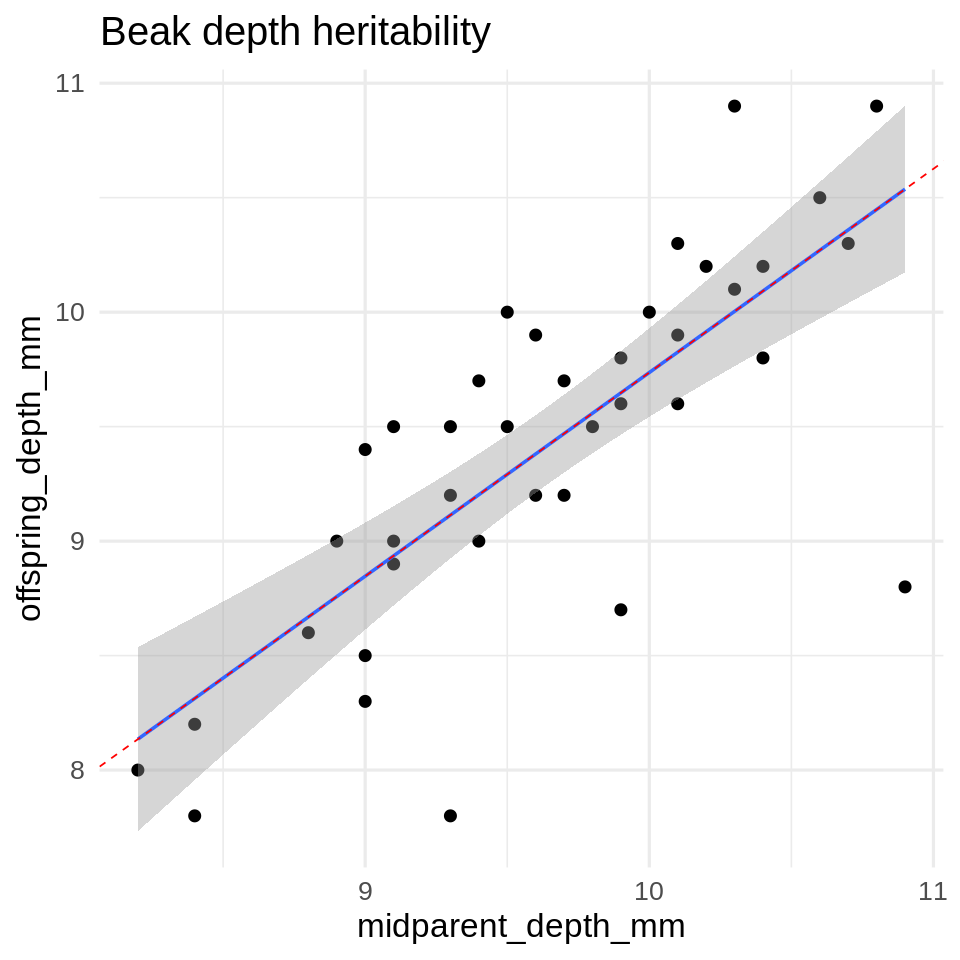

In [41]:
options(repr.plot.height = 8, repr.plot.width = 8)
beak_heritability %>%
  ggplot(aes(x = midparent_depth_mm, y = offspring_depth_mm)) +
    geom_point(size = 3) +
    geom_smooth(method = "lm") +
    geom_abline(
      intercept = coef(m1_heritability)[1],
      slope = coef(m1_heritability)[2],
      linetype = "dashed",
      color = "red"
    ) +
    labs(title = "Beak depth heritability")

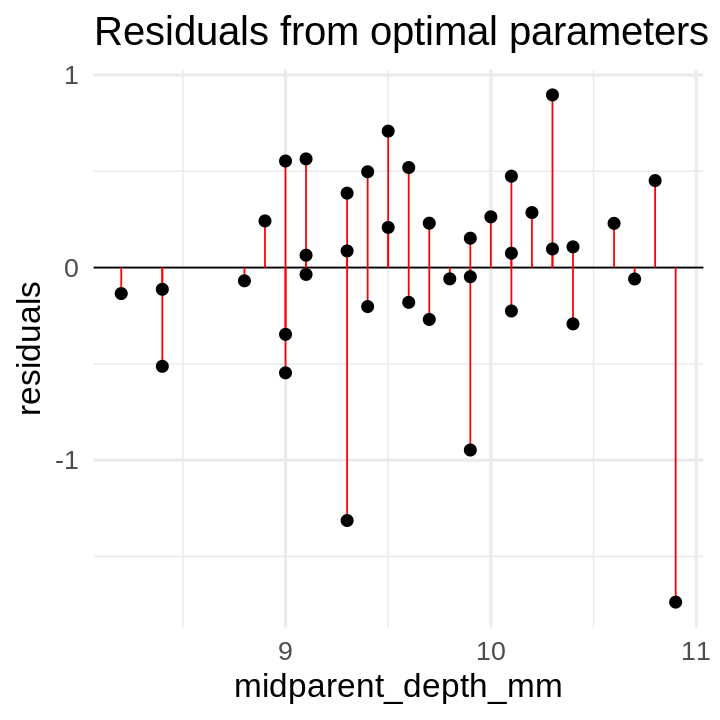

In [42]:
options(repr.plot.height = 6, repr.plot.width = 6)
beak_heritability %>%
  mutate(
    residuals = resid(m1_heritability)
  ) %>%
  ggplot(aes(x = midparent_depth_mm, y = residuals)) +
  geom_hline(yintercept = 0) +
  geom_segment(color = "red", aes(
    xend = midparent_depth_mm,
    yend = 0
  )) +
  geom_point(size=3) +
  labs(title = "Residuals from optimal parameters")

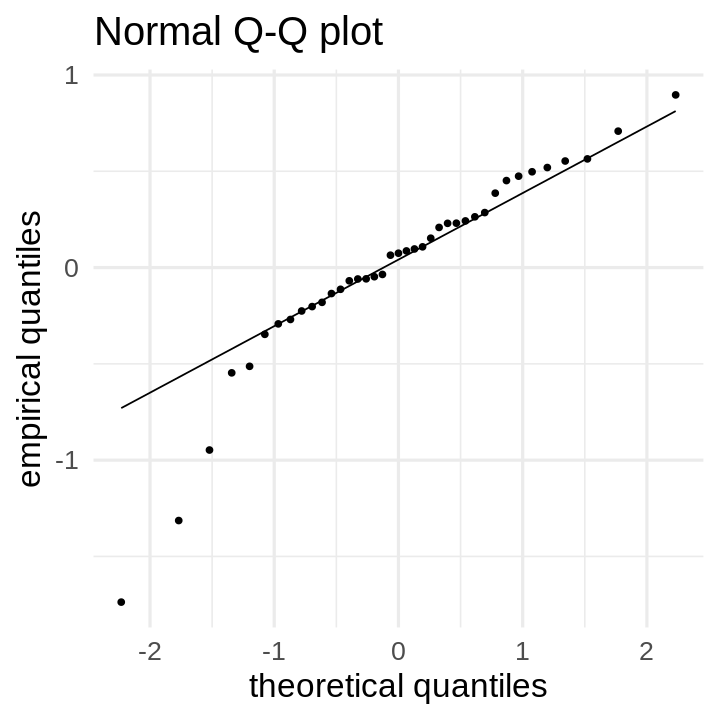

In [43]:
options(repr.plot.height = 6, repr.plot.width = 6)
beak_heritability %>%
  mutate(
    residuals = resid(m1_heritability)
  ) %>%
  ggplot(aes(sample = residuals)) +
    stat_qq() +
    stat_qq_line() +
    labs(
      title = "Normal Q-Q plot",
      y = "empirical quantiles",
      x = "theoretical quantiles"
    )

## Coefficient of determination

The coefficient of determination, $R^2$, measures the fraction of variance in the response variable that's explained (or accounted for) by the model.

$$\underbrace{R^2}_{\text{explained}} = 1 - \underbrace{\frac{\text{RSS}}{\text{TSS}}}_{\text{}unexplained}$$

where RSS is the residual sum of squares (defined earlier), and TSS is the total sum of squares given by

$$\text{TSS} = \sum_{i=1}^n (y_i - \mu)^2.$$

The mean response is given by

$$\mu = \frac{1}{n} \sum_{i = 1}^n y_i$$

The RSS / TSS term quantifies the proportion of unexplained variance (variability in the response after acounting for the linear trend in our model).

When $R^2$ is small, the linear trend tells us very little about the observed variation in the response. When $R^2$ is close 1, the linear trend tells us everything.

In [44]:
TSS <- sum((beak_heritability$offspring_depth_mm - mean(beak_heritability$offspring_depth_mm))^2)
RSS <- sum(resid(m1_heritability)^2)
1 - RSS / TSS

[1] 0.5759688

In [45]:
summary(m1_heritability)$r.squared

[1] 0.5759688

In [46]:
# compare to our guess from earlier
RSS <- sum((beak_heritability$offspring_depth_mm - f(beak_heritability$midparent_depth_mm))^2)
1 - RSS / TSS

[1] 0.4856377

In [47]:
# multiple regression
m2_heritability <- lm(
  offspring_depth_mm ~ midparent_depth_mm + year,
  data = beak_heritability
)

In [48]:
summary(m2_heritability)


Call:
lm(formula = offspring_depth_mm ~ midparent_depth_mm + year, 
    data = beak_heritability)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.37084 -0.15965  0.02022  0.23198  0.80737 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.6457     1.0936   1.505  0.14109    
midparent_depth_mm   0.7821     0.1150   6.802 5.98e-08 ***
year1978             0.5279     0.1546   3.415  0.00159 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4603 on 36 degrees of freedom
Multiple R-squared:  0.6797,	Adjusted R-squared:  0.6619 
F-statistic:  38.2 on 2 and 36 DF,  p-value: 1.256e-09


In [49]:
RSS <- sum(resid(m2_heritability)^2)
1 - RSS / TSS

[1] 0.6797395

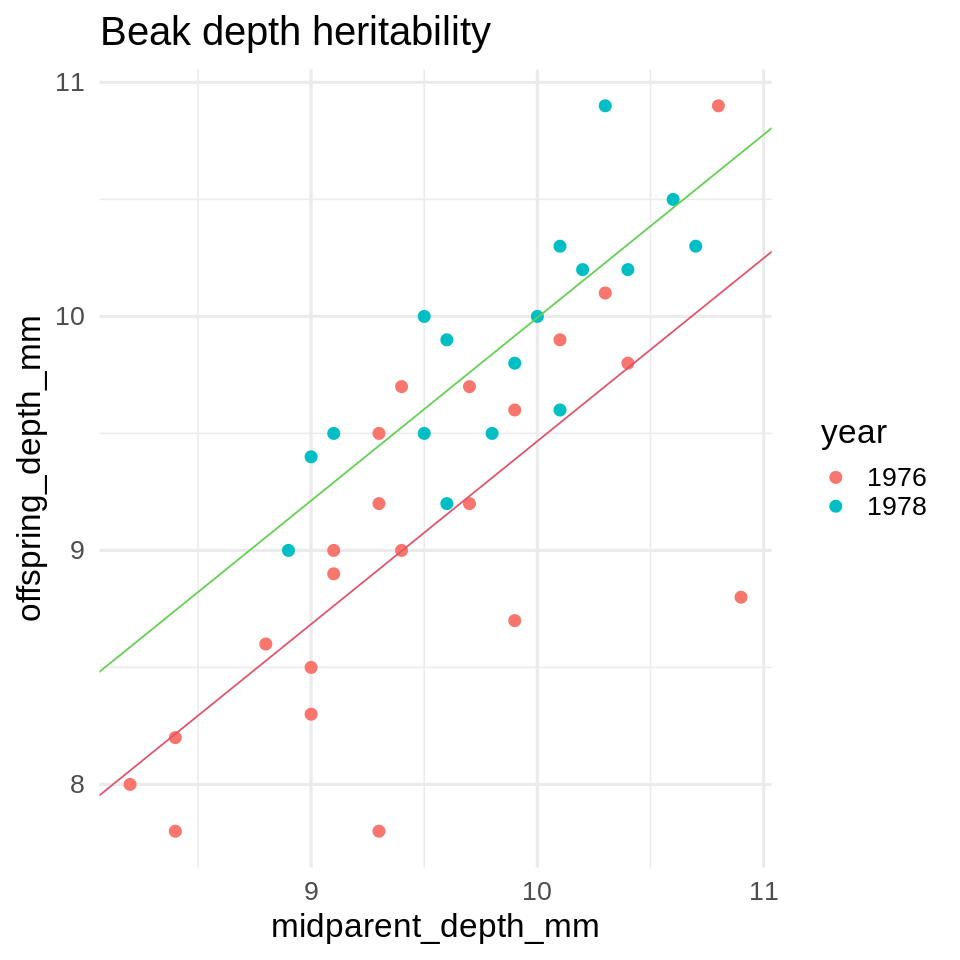

In [50]:
options(repr.plot.height = 8, repr.plot.width = 8)
beak_heritability %>%
  ggplot(aes(x = midparent_depth_mm, y = offspring_depth_mm, color = year)) +
    geom_point(size = 3) +
    geom_abline(
      intercept = coef(m2_heritability)[1],
      slope = coef(m2_heritability)[2],
      color = 2
    ) +
    geom_abline(
      intercept = coef(m2_heritability)[1] + coef(m2_heritability)[3],
      slope = coef(m2_heritability)[2],
      color = 3
    ) +
    labs(title = "Beak depth heritability")

# Model diagnostics

In [ ]:
# warning: slow!
install.packages("performance")
install.packages("see")
install.packages("patchwork")
library(performance)

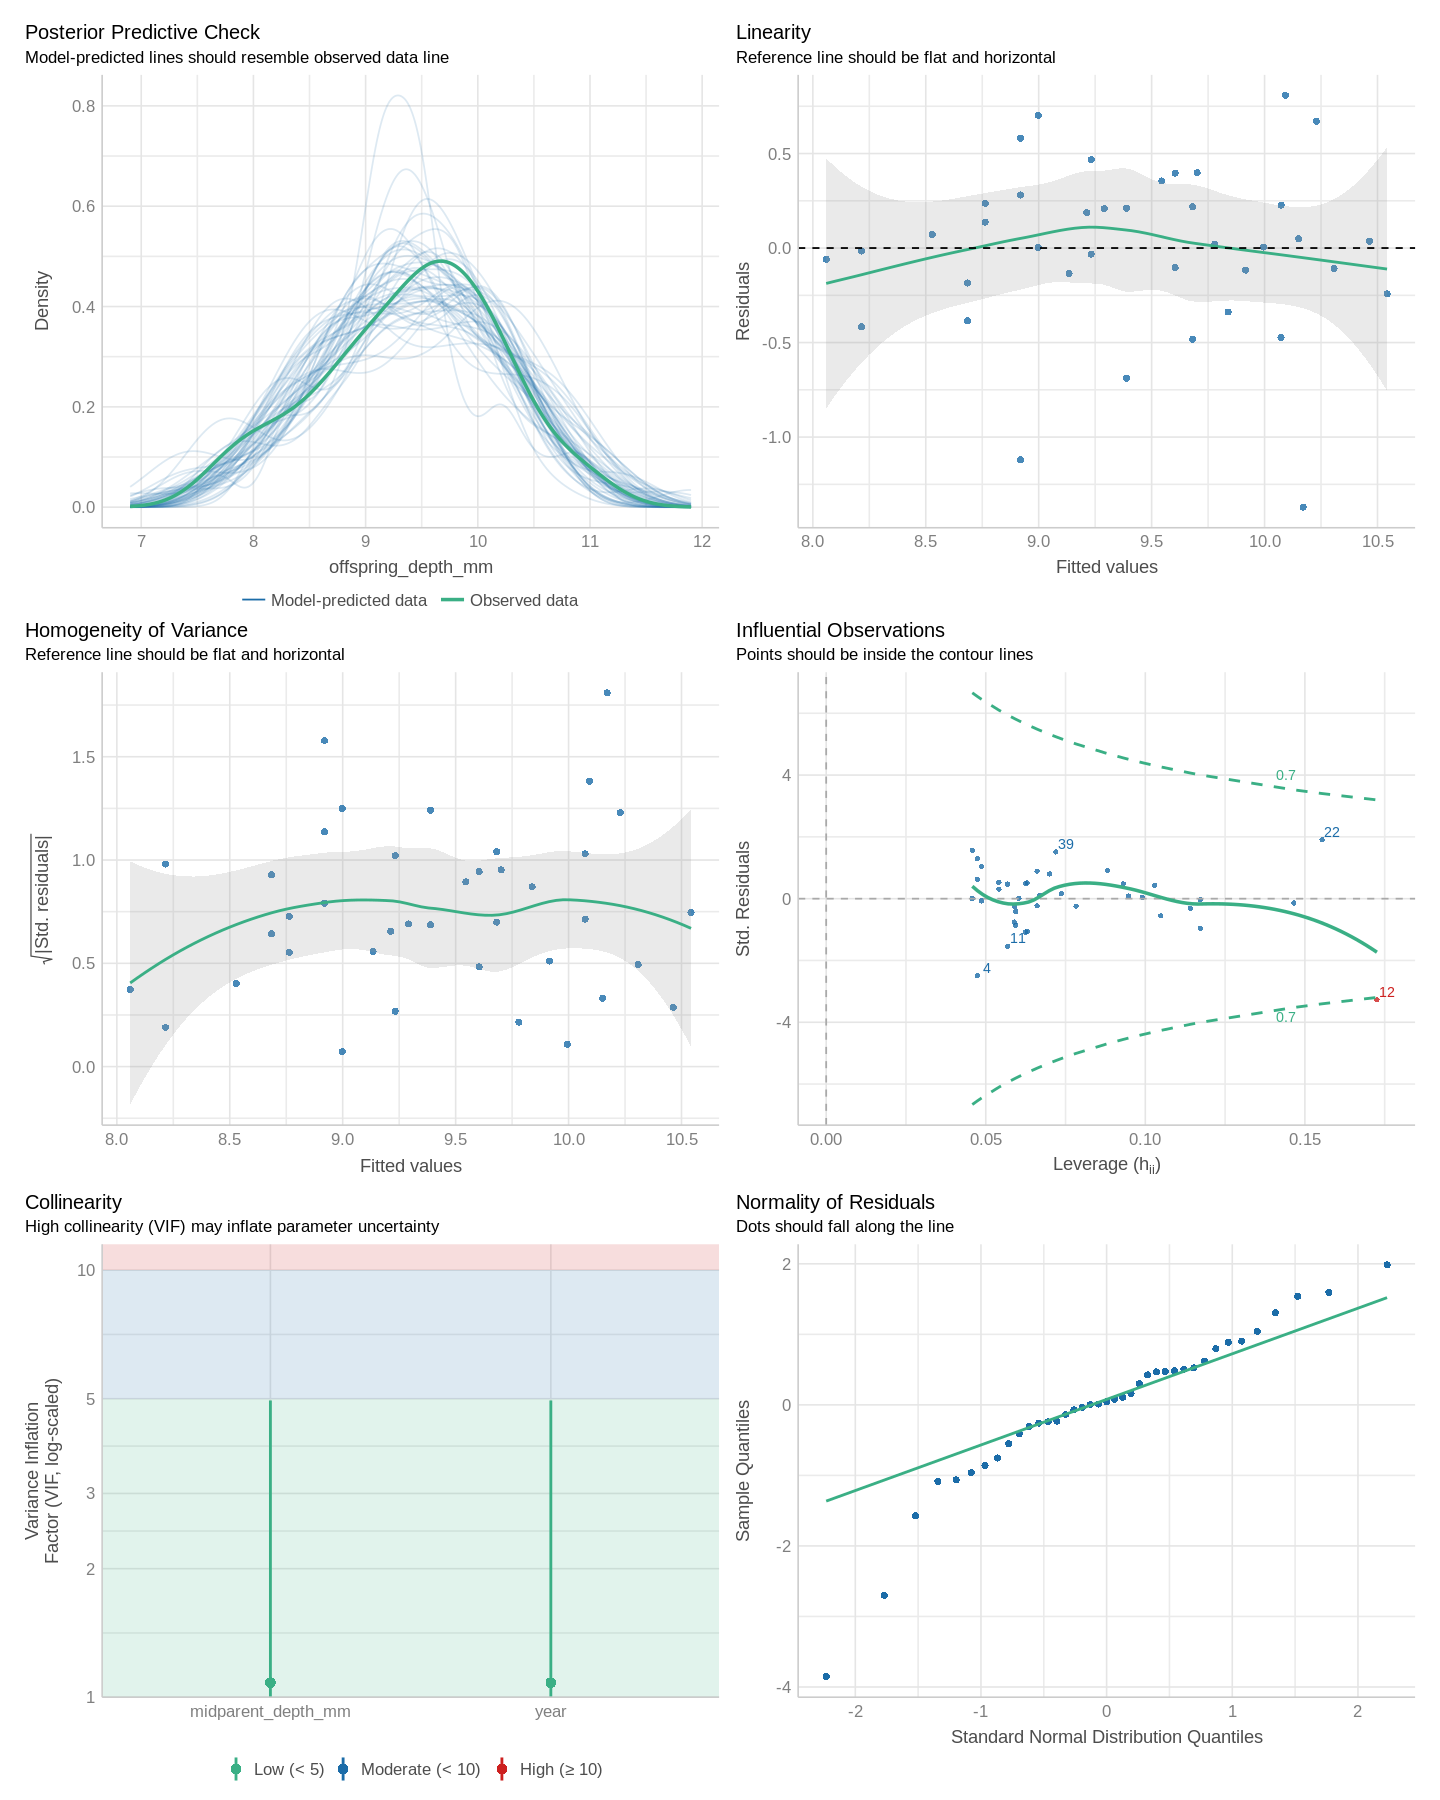

In [126]:
options(repr.plot.height = 15, repr.plot.width = 12)
check_model(m_heritability)

# Model performance

In [108]:
m1 <- lm(
  offspring_depth_mm ~ midparent_depth_mm,
  data = beak_heritability
)

m2 <- lm(
  offspring_depth_mm ~ midparent_depth_mm + year,
  data = beak_heritability
)

compare_performance(m1, m2)

Name,Model,AIC,AIC_wt,BIC,BIC_wt,R2,R2_adjusted,RMSE,Sigma
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m1,lm,63.98210,0.01128304,68.97278,0.02554775,0.5759688,0.5645085,0.5088620,0.5224341
m2,lm,55.03588,0.98871696,61.69013,0.97445225,0.6797395,0.6619472,0.4422348,0.4602925
